# Business case

John is expanding his empire and he wants our help to do it. In his last business trip, he fell in love with India (he did his own version of 'Eat, Pray, Love') so he is considering opening a restaurant in Bangalore. He has no clue of the overall restaurant scene and no theme in mind so he is open to suggestions. 

He has provided us with a database of Zomato, it is like a tripadvisor but very popular in India, to assist us with our analysis.



![](https://legacy.travelnoire.com/wp-content/uploads/2019/05/Bertony-at-the-Table_resized.jpg)

# Action Plan

    1) Clean our datasets
    2) Explore the variables 
    3) Identify the best restaurants
    4) Explore the services, cuisine, price of the best restaurants
    5) Analyze the best location for the new restaurant
    
    
## **Attribute Information:**

    - url: contains the url of the restaurant in the zomato website
    - address: contains the address of the restaurant in Bengaluru
    - name: contains the name of the restaurant
    - online_order: whether online ordering is available in the restaurant or not
    - book_table: table book option available or not
    - rate: contains the overall rating of the restaurant out of 5
    - votes: contains total number of rating for the restaurant 
    - phone: contains the phone number of the restaurant
    - location: contains the neighborhood in which the restaurant is located
    - rest_type: restaurant type
    - dish_liked: dishes people liked in the restaurant
    - cuisines: food styles, separated by comma
    - approx_cost(for two people): contains the approximate cost for meal for two people
    - reviews_list: list of tuples containing reviews for the restaurant, each tuple
    - menu_item: contains list of menus available in the restaurant
    - listed_in(type): type of meal
    - listed_in(city): contains the neighborhood in which the restaurant is listed
    
> datasets:  `P3. ratings.csv`, `P3.locations.csv` and `P3. zomato.csv`    

# 1. Importing the necessary libraries and functions

In [1]:
import re
import time
import nltk
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/Users/patri/Documents/AllWomen/Module_0/_functions_')

from fx_NLP import *
from Functions_EDA import *

[nltk_data] Downloading package stopwords to /Users/patri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/patri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/patri/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 2. Loading the datasets

In [2]:
ratings = pd.read_csv("P3. ratings.csv")
locations = pd.read_csv("P3. locations.csv")

In [3]:
zomato = pd.read_csv("P3. zomato.csv", decimal=',')

# 3. Understanding the datasets

In [4]:
ratings.head()

Unnamed: 0   name  rating  \
0           0  Jalsa     4.0   
1           1  Jalsa     4.0   
2           2  Jalsa     2.0   
3           3  Jalsa     4.0   
4           4  Jalsa     5.0   

                                              review  
0  A beautiful place to dine inThe interiors take...  
1  I was here for dinner with my family on a week...  
2  Its a restaurant near to Banashankari BDA Me a...  
3  We went here on a weekend and one of us had th...  
4  The best thing about the place is its ambiance...

In [5]:
locations.head()

Name                         geo_loc
0        Bangalore Banashankari         (12.9152208, 77.573598)
1        Bangalore Basavanagudi        (12.9417261, 77.5755021)
2         Bangalore Mysore Road        (12.9314092, 77.5067138)
3           Bangalore Jayanagar        (12.9292731, 77.5824229)
4  Bangalore Kumaraswamy Layout  (12.9068169, 77.5635247362134)

In [6]:
zomato.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines  approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                        800.0   
1     Chinese, North Indian, Thai                        800.0   
2          Cafe, Mexican, Italian                        800.0   
3      South Indian, North Indian                        300.0   
4        North Indian, Rajasthani                        600.0   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319968 entries, 0 to 1319967
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1319968 non-null  int64  
 1   name        1319968 non-null  object 
 2   rating      1319968 non-null  float64
 3   review      1316924 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 40.3+ MB


In [8]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     94 non-null     object
 1   geo_loc  88 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [9]:
zomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   url                          51717 non-null  object 
 1   address                      51717 non-null  object 
 2   name                         51717 non-null  object 
 3   online_order                 51717 non-null  object 
 4   book_table                   51717 non-null  object 
 5   rate                         43942 non-null  object 
 6   votes                        51717 non-null  int64  
 7   phone                        50509 non-null  object 
 8   location                     51696 non-null  object 
 9   rest_type                    51490 non-null  object 
 10  dish_liked                   23639 non-null  object 
 11  cuisines                     51672 non-null  object 
 12  approx_cost(for two people)  51371 non-null  float64
 13  reviews_list    

#### From a quick look, we can see that there are missing values that need to be dropped, and also that our datasets are very different in dimension.

# 4. Basic Data Cleaning and EDA

## - Dealing with missing values

In [10]:
ratings_c = ratings.copy()
locations_c = locations.copy()
zomato_c = zomato.copy()

#### The best thing to do is to create copies of all the datasets before we start dropping columns and values.

In [11]:
ratings.head(2)

Unnamed: 0   name  rating  \
0           0  Jalsa     4.0   
1           1  Jalsa     4.0   

                                              review  
0  A beautiful place to dine inThe interiors take...  
1  I was here for dinner with my family on a week...

In [12]:
ratings.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [13]:
ratings.head(2)

name  rating                                             review
0  Jalsa     4.0  A beautiful place to dine inThe interiors take...
1  Jalsa     4.0  I was here for dinner with my family on a week...

In [14]:
ratings.isnull().sum()

name         0
rating       0
review    3044
dtype: int64

In [15]:
ratings.dropna(inplace = True)

In [16]:
ratings.isnull().sum() #Always making sure that the nan values have been dropped!

name      0
rating    0
review    0
dtype: int64

In [17]:
locations.head(2)

Name                   geo_loc
0  Bangalore Banashankari   (12.9152208, 77.573598)
1  Bangalore Basavanagudi  (12.9417261, 77.5755021)

In [18]:
locations.isnull().sum()  #since the important information from this dataset is the name of the location, I think it is better to keep them

Name       0
geo_loc    6
dtype: int64

In [19]:
zomato.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [20]:
zomato.dropna(inplace=True)

In [21]:
zomato.isnull().sum()

url                            0
address                        0
name                           0
online_order                   0
book_table                     0
rate                           0
votes                          0
phone                          0
location                       0
rest_type                      0
dish_liked                     0
cuisines                       0
approx_cost(for two people)    0
reviews_list                   0
menu_item                      0
listed_in(type)                0
listed_in(city)                0
dtype: int64

In [22]:
zomato.shape

(23193, 17)

In [23]:
zomato_c.shape

(51717, 17)

In [24]:
ratings.shape

(1316924, 3)

In [25]:
ratings_c.shape

(1319968, 4)

## - Dealing with duplicates

In [26]:
ratings.duplicated().sum()

1185319

In [27]:
ratings.drop_duplicates(inplace=True)

In [28]:
ratings.shape

(131605, 3)

In [29]:
locations.nunique()

Name       94
geo_loc    79
dtype: int64

In [30]:
locations.duplicated().sum()

0

In [31]:
zomato.duplicated().sum()

0

## - Dealing with outliers

In [188]:
OutLiersBox(zomato,"approx_cost(for two people)")

/Users/patri/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/patri/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### After exploring the datasets, in my opinion, the best thing to do for this particular business case is to focus on Zomato

In [32]:
zomato.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines  approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                        800.0   
1     Chinese, North Indian, Thai                        800.0   
2          Cafe, Mexican, Italian                        800.0   
3      South Indian, North Indian                        300.0   
4        North Indian, Rajasthani                        600.0   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

#### I don't think the url , the menu_item, the address nor the phone number are important, let's drop them!

In [33]:
zomato.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [34]:
zomato.drop(["url", "address", "phone", "menu_item"], axis = 1, inplace = True)

#### I can also rename some of the columns:

In [35]:
zomato.rename(columns={'listed_in(type)': 'type', 'listed_in(city)': 'neighbourhood', "approx_cost(for two people)" : "approx_cost"}, inplace = True)

In [36]:
zomato

name online_order  \
0                                                  Jalsa          Yes   
1                                         Spice Elephant          Yes   
2                                        San Churro Cafe          Yes   
3                                  Addhuri Udupi Bhojana           No   
4                                          Grand Village           No   
...                                                  ...          ...   
51705                                 Izakaya Gastro Pub          Yes   
51707        M Bar - Bengaluru Marriott Hotel Whitefield           No   
51708                             Keys Cafe - Keys Hotel           No   
51711                                            Bhagini           No   
51715  Chime - Sheraton Grand Bengaluru Whitefield Ho...           No   

      book_table    rate  votes                    location  \
0            Yes   4.1/5    775                Banashankari   
1             No   4.1/5    787                Banashankari   
2             No   3.8/5    918                Banashankari   
3             No   3.7/5     88                Banashankari   
4             No   3.8/5    166                Basavanagudi   
...          ...     ...    ...                         ...   
51705        Yes  3.8 /5    128                  Whitefield   
51707         No  3.9 /5     77                  Whitefield   
51708         No  2.8 /5    161                  Whitefield   
51711         No  2.5 /5     81                  Whitefield   
51715        Yes  4.3 /5    236  ITPL Main Road, Whitefield   

                 rest_type                                         dish_liked  \
0            Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1            Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2      Cafe, Casual Dining  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3              Quick Bites                                        Masala Dosa   
4            Casual Dining                                Panipuri, Gol Gappe   
...                    ...                                                ...   
51705   Bar, Casual Dining  Beer, Chicken Guntur, Paneer Tikka, Fish, Nood...   
51707     Fine Dining, Bar                                   Rooftop Ambience   
51708   Casual Dining, Bar  Salads, Coffee, Breakfast Buffet, Halwa, Chick...   
51711   Casual Dining, Bar                               Biryani, Andhra Meal   
51715                  Bar                       Cocktails, Pizza, Buttermilk   

                                          cuisines  approx_cost  \
0                   North Indian, Mughlai, Chinese        800.0   
1                      Chinese, North Indian, Thai        800.0   
2                           Cafe, Mexican, Italian        800.0   
3                       South Indian, North Indian        300.0   
4                         North Indian, Rajasthani        600.0   
...                                            ...          ...   
51705     North Indian, Continental, Mediterranean          1.2   
51707                                  Finger Food          2.0   
51708           Chinese, Continental, North Indian          1.2   
51711  Andhra, South Indian, Chinese, North Indian        800.0   
51715                                  Finger Food          2.5   

                                            reviews_list           type  \
0      [('Rated 4.0', 'RATED\n  A beautiful place to ...         Buffet   
1      [('Rated 4.0', 'RATED\n  Had been here for din...         Buffet   
2      [('Rated 3.0', "RATED\n  Ambience is not that ...         Buffet   
3      [('Rated 4.0', "RATED\n  Great food and proper...         Buffet   
4      [('Rated 4.0', 'RATED\n  Very good restaurant ...         Buffet   
...                                                  ...            ...   
51705  [('Rated 3.0', "RATED\n  Nice place to hangout...  Pubs and bars   
51707  [('Rated 4.0', 'RATED\n  Went the

### Let's change the ratings to a different format:

In [37]:
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23193 entries, 0 to 51715
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           23193 non-null  object 
 1   online_order   23193 non-null  object 
 2   book_table     23193 non-null  object 
 3   rate           23193 non-null  object 
 4   votes          23193 non-null  int64  
 5   location       23193 non-null  object 
 6   rest_type      23193 non-null  object 
 7   dish_liked     23193 non-null  object 
 8   cuisines       23193 non-null  object 
 9   approx_cost    23193 non-null  float64
 10  reviews_list   23193 non-null  object 
 11  type           23193 non-null  object 
 12  neighbourhood  23193 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 2.5+ MB


In [38]:
zomato["rate"].unique()

array(['4.1/5', '3.8/5', '3.7/5', '4.6/5', '4.0/5', '4.2/5', '3.9/5',
       '3.0/5', '3.6/5', '2.8/5', '4.4/5', '3.1/5', '4.3/5', '2.6/5',
       '3.3/5', '3.5/5', '3.8 /5', '3.2/5', '4.5/5', '2.5/5', '2.9/5',
       '3.4/5', '2.7/5', '4.7/5', 'NEW', '2.4/5', '2.2/5', '2.3/5',
       '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5', '4.1 /5', '2.9 /5',
       '2.7 /5', '2.5 /5', '2.6 /5', '4.5 /5', '4.3 /5', '3.7 /5',
       '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '3.4 /5', '3.6 /5',
       '3.3 /5', '4.6 /5', '4.9 /5', '3.2 /5', '3.0 /5', '2.8 /5',
       '3.5 /5', '3.1 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [39]:
zomato.rate = zomato.rate.str.replace("/5", "")

In [40]:
zomato.rate = zomato.rate.str.replace(" /5", "")

In [41]:
zomato

name online_order  \
0                                                  Jalsa          Yes   
1                                         Spice Elephant          Yes   
2                                        San Churro Cafe          Yes   
3                                  Addhuri Udupi Bhojana           No   
4                                          Grand Village           No   
...                                                  ...          ...   
51705                                 Izakaya Gastro Pub          Yes   
51707        M Bar - Bengaluru Marriott Hotel Whitefield           No   
51708                             Keys Cafe - Keys Hotel           No   
51711                                            Bhagini           No   
51715  Chime - Sheraton Grand Bengaluru Whitefield Ho...           No   

      book_table  rate  votes                    location  \
0            Yes   4.1    775                Banashankari   
1             No   4.1    787                Banashankari   
2             No   3.8    918                Banashankari   
3             No   3.7     88                Banashankari   
4             No   3.8    166                Basavanagudi   
...          ...   ...    ...                         ...   
51705        Yes  3.8     128                  Whitefield   
51707         No  3.9      77                  Whitefield   
51708         No  2.8     161                  Whitefield   
51711         No  2.5      81                  Whitefield   
51715        Yes  4.3     236  ITPL Main Road, Whitefield   

                 rest_type                                         dish_liked  \
0            Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1            Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2      Cafe, Casual Dining  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3              Quick Bites                                        Masala Dosa   
4            Casual Dining                                Panipuri, Gol Gappe   
...                    ...                                                ...   
51705   Bar, Casual Dining  Beer, Chicken Guntur, Paneer Tikka, Fish, Nood...   
51707     Fine Dining, Bar                                   Rooftop Ambience   
51708   Casual Dining, Bar  Salads, Coffee, Breakfast Buffet, Halwa, Chick...   
51711   Casual Dining, Bar                               Biryani, Andhra Meal   
51715                  Bar                       Cocktails, Pizza, Buttermilk   

                                          cuisines  approx_cost  \
0                   North Indian, Mughlai, Chinese        800.0   
1                      Chinese, North Indian, Thai        800.0   
2                           Cafe, Mexican, Italian        800.0   
3                       South Indian, North Indian        300.0   
4                         North Indian, Rajasthani        600.0   
...                                            ...          ...   
51705     North Indian, Continental, Mediterranean          1.2   
51707                                  Finger Food          2.0   
51708           Chinese, Continental, North Indian          1.2   
51711  Andhra, South Indian, Chinese, North Indian        800.0   
51715                                  Finger Food          2.5   

                                            reviews_list           type  \
0      [('Rated 4.0', 'RATED\n  A beautiful place to ...         Buffet   
1      [('Rated 4.0', 'RATED\n  Had been here for din...         Buffet   
2      [('Rated 3.0', "RATED\n  Ambience is not that ...         Buffet   
3      [('Rated 4.0', "RATED\n  Great food and proper...         Buffet   
4      [('Rated 4.0', 'RATED\n  Very good restaurant ...         Buffet   
...                                                  ...            ...   
51705  [('Rated 3.0', "RATED\n  Nice place to hangout...  Pubs and bars   
51707  [('Rated 4.0', 'RATED\n  Went there post dinne...  Pubs a

In [42]:
#zomato["rate"] = pd.to_numeric(zomato["rate"])

In [43]:
zomato[zomato["rate"] == 'NEW']

name online_order book_table rate  votes  \
1011                      Le Arabia          Yes         No  NEW      0   
2239                   Brahma Brews           No        Yes  NEW      0   
2240   Levitate Brewery and Kitchen           No        Yes  NEW      0   
2250                      Le Arabia          Yes         No  NEW      0   
2258                        Nourich           No        Yes  NEW      0   
...                             ...          ...        ...  ...    ...   
50032             Parrattha Ssinghh          Yes         No  NEW      0   
50050           Deli Chats & Sweets          Yes         No  NEW      0   
50135                        Potful          Yes         No  NEW      0   
50571                    Temptation          Yes         No  NEW      0   
51386                    Temptation          Yes         No  NEW      0   

         location                    rest_type  \
1011     JP Nagar                Casual Dining   
2239     JP Nagar  Microbrewery, Casual Dining   
2240     JP Nagar  Microbrewery, Casual Dining   
2250     JP Nagar                Casual Dining   
2258     JP Nagar                Casual Dining   
...           ...                          ...   
50032   Bellandur                  Quick Bites   
50050   Bellandur                  Quick Bites   
50135  Whitefield                     Delivery   
50571  Whitefield                  Quick Bites   
51386  Whitefield                  Quick Bites   

                                              dish_liked  \
1011                                     Chicken Biryani   
2239   Beer, Cocktails, Pizza, Peri Chicken, Belgian ...   
2240   Wheat Beer, Lager, Paneer Lollipop, Rustica Pi...   
2250                                     Chicken Biryani   
2258     Soba Noodles, Pad Thai Noodle, Chicken Sandwich   
...                                                  ...   
50032                                            Paratha   
50050  Chaat, Tea, Sev Puri, Chai, Raj Kachori, Coffe...   
50135             Hyderabadi Biryani, Rumali Roti, Raita   
50571                                       Mutton Curry   
51386                                       Mutton Curry   

                                                cuisines  approx_cost  \
1011                               North Indian, Mughlai        600.0   
2239   Continental, South Indian, Finger Food, Pizza,...          1.4   
2240              Finger Food, North Indian, Continental          1.5   
2250                               North Indian, Mughlai        600.0   
2258   Continental, Chinese, North Indian, Asian, Hea...        800.0   
...                                                  ...          ...   
50032                                       North Indian        250.0   
50050                                Street Food, Mithai        200.0   
50135                     Biryani, Kebab, Rolls, Mughlai        650.0   
50571                                       North Indian        500.0   
51386                                       North Indian        500.0   

                                            reviews_list      type  \
1011   [('Rated 4.0', "RATED\n  Very good Arabian sty...  Delivery   
2239   [('Rated 4.0', 'RATED\n  This huge property lo...  Dine-out   
2240   [('Rated 4.0', 'RATED\n  A new brewery has com...  Dine-out   
2250   [('Rated 4.0', "RATED\n  Very good Arabian sty...  Dine-out   
2258   [('Rated 5.0', 'RATED\n  The ambience is reall...  Dine-out   
...                                                  ...       ...   
50032  [('Rated 5.0', 'RATED\n  Aloo paratha and pane...  Dine-out   
50050  [('Rated 5.0', 'RATED\n  Deli chaats and sweet...  Dine-out   
50135  [('Rated 2.0', 'RATED\n  I had ordered a coupl...  Delivery   
50571  [('Rated 5.0', 'RATED\n  Just to say Ã\x83Ã\...  Delivery   
51386  [('Rated 5.0', 'RATED\n  Just to say Ã\x83Ã\...  Dine-out   

           neighbourhood  
1011   Bannerghatta Road  
2239   Bannerghatta Road  
2240   Ba

In [44]:
new_zomato = zomato[zomato["rate"].str.contains("NEW") == False]

In [45]:
new_zomato = new_zomato[new_zomato["rate"].str.contains("-") == False]

In [46]:
new_zomato["rate"] = pd.to_numeric(new_zomato["rate"])

In [47]:
new_zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23046 entries, 0 to 51715
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           23046 non-null  object 
 1   online_order   23046 non-null  object 
 2   book_table     23046 non-null  object 
 3   rate           23046 non-null  float64
 4   votes          23046 non-null  int64  
 5   location       23046 non-null  object 
 6   rest_type      23046 non-null  object 
 7   dish_liked     23046 non-null  object 
 8   cuisines       23046 non-null  object 
 9   approx_cost    23046 non-null  float64
 10  reviews_list   23046 non-null  object 
 11  type           23046 non-null  object 
 12  neighbourhood  23046 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.5+ MB


In [48]:
new_zomato.rate.value_counts()

3.9    3238
4.0    2860
4.1    2786
3.8    2473
4.2    2097
4.3    1671
3.7    1639
4.4    1123
3.6     875
4.5     630
3.5     482
3.4     351
2.8     315
2.9     309
3.1     307
4.6     294
3.0     291
3.2     249
3.3     218
2.7     190
4.7     167
2.6     138
4.8      66
2.5      57
4.9      55
2.4      54
2.3      45
2.2      26
2.1      24
2.0      11
1.8       5
Name: rate, dtype: int64

#### Now the variable rate is numerical!

### Let's create two df, one with the highest ratings and another one with the lowest ratings

In [49]:
new_zomato.rate.describe()

count    23046.000000
mean         3.904383
std          0.426365
min          1.800000
25%          3.800000
50%          4.000000
75%          4.200000
max          4.900000
Name: rate, dtype: float64

In [50]:
highest_ratings = new_zomato[new_zomato["rate"]>= 4.0]

In [51]:
highest_ratings.shape

(11749, 13)

In [52]:
lowest_ratings = new_zomato[new_zomato["rate"]<= 3.0]

In [53]:
lowest_ratings.shape

(1465, 13)

# 5. NLP Preprocessing

In [54]:
highest_ratings['reviews_list'][:20]

0     [('Rated 4.0', 'RATED\n  A beautiful place to ...
1     [('Rated 4.0', 'RATED\n  Had been here for din...
7     [('Rated 5.0', 'RATED\n  I personally really l...
8     [('Rated 3.0', "RATED\n  I had been to this pl...
9     [('Rated 4.0', "RATED\n  Easy to locate\nVFM 3...
10    [('Rated 4.0', 'RATED\n  We ended up here on a...
11    [('Rated 1.0', "RATED\n \n\nHorrible. Not even...
12    [('Rated 4.0', "RATED\n  Food - 4/5\nAmbience ...
13    [('Rated 2.0', "RATED\n  This is a hookah cafe...
30    [('Rated 4.0', "RATED\n  Redberrys will provid...
34    [('Rated 3.0', 'RATED\n  Not worth for the mon...
37    [('Rated 4.0', 'RATED\n  Located near BMS coll...
38    [('Rated 3.0', 'RATED\n  Grill and tandoori is...
44    [('Rated 5.0', 'RATED\n  I personally really l...
47    [('Rated 3.0', "RATED\n  Ordered Paneer meal v...
52    [('Rated 3.0', "RATED\n  Always a fan of corne...
53    [('Rated 5.0', "RATED\n  Dear Biryanis and mor...
54    [('Rated 5.0', "RATED\n  Momooooooooooo...

In [55]:
def clean_text1(text, language):
    '''Make text lowercase, remove text in square brackets,
    remove links,remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove urls, https
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text) #get rid of digits, ie numbers
    text = re.sub(r'\brated\b\s+',"", text)
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    
    remove_stopwords = [w for w in text if w not in stop_words]
    combined_text = ' '.join(remove_stopwords)
    return combined_text
    return text

In [56]:
highest_ratings['text_clean'] = highest_ratings['reviews_list'].apply(lambda x : clean_text1(x, "english"))

In [57]:
highest_ratings

name online_order  \
0                                                  Jalsa          Yes   
1                                         Spice Elephant          Yes   
7                                                 Onesta          Yes   
8                                         Penthouse Cafe          Yes   
9                                              Smacznego          Yes   
...                                                  ...          ...   
51700                                            BAR BAR           No   
51701                                      The Beer Cafe          Yes   
51702                                  Pablo's Gastrobar           No   
51704                                            Smaaash           No   
51715  Chime - Sheraton Grand Bengaluru Whitefield Ho...           No   

      book_table  rate  votes                    location  \
0            Yes   4.1    775                Banashankari   
1             No   4.1    787                Banashankari   
7            Yes   4.6   2556                Banashankari   
8             No   4.0    324                Banashankari   
9             No   4.2    504                Banashankari   
...          ...   ...    ...                         ...   
51700        Yes   4.1   1003                  Whitefield   
51701        Yes   4.1    673                  Whitefield   
51702         No   4.0   1094                  Whitefield   
51704        Yes   4.0    189                  Whitefield   
51715        Yes   4.3    236  ITPL Main Road, Whitefield   

                 rest_type                                         dish_liked  \
0            Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1            Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
7      Casual Dining, Cafe  Farmhouse Pizza, Chocolate Banana, Virgin Moji...   
8                     Cafe  Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...   
9                     Cafe  Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...   
...                    ...                                                ...   
51700   Bar, Casual Dining  Mocktails, Cocktails, Pizza, Chicken Tikka, Na...   
51701                  Pub  Cocktails, Wheat Beer, Bruschettas, Pasta, Bur...   
51702                  Bar  Cocktails, Beer, Pizza, Long Island Iced Tea, ...   
51704   Casual Dining, Pub                                        Pizza, Beer   
51715                  Bar                       Cocktails, Pizza, Buttermilk   

                                          cuisines  approx_cost  \
0                   North Indian, Mughlai, Chinese       800.00   
1                      Chinese, North Indian, Thai       800.00   
7                             Pizza, Cafe, Italian       600.00   
8                       Cafe, Italian, Continental       700.00   
9         Cafe, Mexican, Italian, Momos, Beverages       550.00   
...                                            ...          ...   
51700           Continental, North Indian, Italian         1.50   
51701  Finger Food, North Indian, Chinese, Italian         1.40   
51702        Finger Food, American, Asian, Italian         1.45   
51704                 North Indian, Pizza, Chinese         1.50   
51715                                  Finger Food         2.50   

                                            reviews_list           type  \
0      [('Rated 4.0', 'RATED\n  A beautiful place to ...         Buffet   
1      [('Rated 4.0', 'RATED\n  Had been here for din...         Buffet   
7      [('Rated 5.0', 'RATED\n  I personally really l...          Cafes   
8      [('Rated 3.0', "RATED\n  I had been to this pl...          Cafes   
9      [('Rated 4.0', "RATED\n  Easy to locate\nVFM 3...          Cafes   
...                                                  ...            ...   
51700  [('Rated 4.0', "RATED\n  In an increasingly ov...  Pubs and bars   
51701  [('Rated 2.0', "RATED\n  We went out to this p...  Pubs a

In [58]:
all_words_clean1 = highest_ratings['text_clean'].str.split(expand=True).unstack().value_counts()

In [59]:
import plotly.express as px
px.bar(all_words_clean1, x = all_words_clean1.index[:20],
      y = all_words_clean1.values[:20], 
      color = all_words_clean1.values[:20],
      title = 'Top 20 word frequencies in the best reviews',
      labels=dict(x='Words', y='Frequency'))

#This is good to see if we need to drop words that are not relevant for this particular project

In [60]:
lowest_ratings['text_clean'] = lowest_ratings['reviews_list'].apply(lambda x : clean_text1(x, "english"))

In [61]:
all_words_clean2 = lowest_ratings['text_clean'].str.split(expand=True).unstack().value_counts()

In [62]:
import plotly.express as px
px.bar(all_words_clean2, x = all_words_clean2.index[:20],
      y = all_words_clean2.values[:20], 
      color = all_words_clean2.values[:20],
      title = 'Top 20 word frequencies in the worst reviews',
      labels=dict(x='Words', y='Frequency'))

In [63]:
list_words = ["food","peri","ratedn", "place", "one", "also", "try", "visit", "time", "ordered", "order", "like", "restaurant", "â", "really", "ã", "dont"]

In [64]:
def text_preprocessing_updated1(text, list_words):
    """
    Cleaning and parsing the text.
    """
    # 1. Tokenize the cleaned_text
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    # 2. Remove punctuations and stopwords
    text = tokenizer.tokenize(text)
    
    # 3. Update the stop_words

    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(list_words)
    
    
    remove_stopwords = [w for w in text if w not in stop_words]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [65]:
highest_ratings['text_clean'] = highest_ratings['text_clean'].apply(lambda x : text_preprocessing_updated1(x, list_words))

In [66]:
highest_ratings.head(2)

name online_order book_table  rate  votes      location  \
0           Jalsa          Yes        Yes   4.1    775  Banashankari   
1  Spice Elephant          Yes         No   4.1    787  Banashankari   

       rest_type                                         dish_liked  \
0  Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   

                         cuisines  approx_cost  \
0  North Indian, Mughlai, Chinese        800.0   
1     Chinese, North Indian, Thai        800.0   

                                        reviews_list    type neighbourhood  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...  Buffet  Banashankari   
1  [('Rated 4.0', 'RATED\n  Had been here for din...  Buffet  Banashankari   

                                          text_clean  
0  beautiful dine inthe interiors take back mugha...  
1  dinner family turned good choose suitable ages...

In [67]:
lowest_ratings['text_clean'] = lowest_ratings['text_clean'].apply(lambda x : text_preprocessing_updated1(x, list_words))

In [68]:
lowest_ratings.head(2)

name online_order book_table  rate  votes      location  \
20  The Vintage Cafe          Yes         No   3.0     62  Banashankari   
31        Foodiction          Yes         No   2.8    506  Banashankari   

      rest_type                                         dish_liked  \
20         Cafe  Burgers, Caramel Milkshake, Iced Coffee, Iced Tea   
31  Quick Bites  Burgers, Lassi, Chicken Grill, Naan, Momos, Ch...   

                                    cuisines  approx_cost  \
20                Cafe, French, North Indian        400.0   
31  North Indian, Fast Food, Chinese, Burger        500.0   

                                         reviews_list      type neighbourhood  \
20  [('Rated 2.0', "RATED\n  This is a tiny cafÃ\...     Cafes  Banashankari   
31  [('Rated 1.0', "RATED\n  Worst restaurant ever...  Delivery  Banashankari   

                                           text_clean  
20  tiny cafã located opposite kathriguppe water t...  
31  worst ever veg manchurian worth doesnt even fi...

In [69]:
highest_ratings['text_tokens'] = highest_ratings['text_clean'].apply(lambda x: word_tokenize(x))

In [70]:
lowest_ratings['text_tokens'] = lowest_ratings['text_clean'].apply(lambda x: word_tokenize(x))

In [71]:
lowest_ratings.head(2)

name online_order book_table  rate  votes      location  \
20  The Vintage Cafe          Yes         No   3.0     62  Banashankari   
31        Foodiction          Yes         No   2.8    506  Banashankari   

      rest_type                                         dish_liked  \
20         Cafe  Burgers, Caramel Milkshake, Iced Coffee, Iced Tea   
31  Quick Bites  Burgers, Lassi, Chicken Grill, Naan, Momos, Ch...   

                                    cuisines  approx_cost  \
20                Cafe, French, North Indian        400.0   
31  North Indian, Fast Food, Chinese, Burger        500.0   

                                         reviews_list      type neighbourhood  \
20  [('Rated 2.0', "RATED\n  This is a tiny cafÃ\...     Cafes  Banashankari   
31  [('Rated 1.0', "RATED\n  Worst restaurant ever...  Delivery  Banashankari   

                                           text_clean  \
20  tiny cafã located opposite kathriguppe water t...   
31  worst ever veg manchurian worth doesnt even fi...   

                                          text_tokens  
20  [tiny, cafã, located, opposite, kathriguppe, w...  
31  [worst, ever, veg, manchurian, worth, doesnt, ...

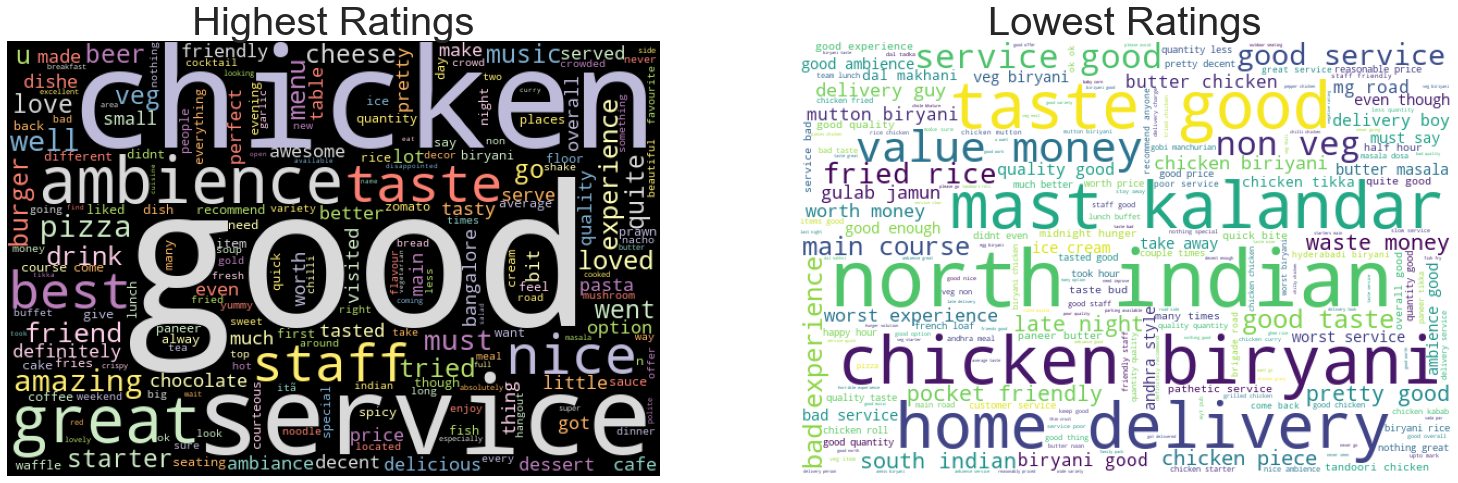

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud(background_color='black',
                        width=600,
                        height=400, colormap='Set3', collocations=False).generate(" ".join(highest_ratings["text_clean"]))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Highest Ratings',fontsize=40)

wordcloud2 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(lowest_ratings["text_clean"]))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Lowest Ratings',fontsize=40);

# 6. Deeper Exploration

### Best restaurants

In [73]:
top_restaurants = highest_ratings["name"].value_counts().reset_index()

In [74]:
top_5_restaurants = top_restaurants.head()

In [75]:
top_5_restaurants

index  name
0                  Onesta    85
1     Smally's Resto Cafe    54
2  Corner House Ice Cream    52
3       Empire Restaurant    52
4          Mainland China    45

In [76]:
top_5_restaurants.columns = ["name of the restaurants", "number of ratings"]

In [77]:
fig_bar = px.bar(top_5_restaurants, y = 'number of ratings', 
                 x= 'name of the restaurants', color= 'name of the restaurants', color_discrete_sequence=px.colors.qualitative.Dark2)
fig_bar.update_layout(title= 'Distribution of the 5 top highest rated restaurants')
fig_bar.show()

In [78]:
color_sequence = [""]

In [79]:
onesta = highest_ratings.loc[highest_ratings["name"].str.contains("Onesta")]

In [80]:
onesta.cuisines.value_counts()

Pizza, Cafe, Italian    85
Name: cuisines, dtype: int64

In [81]:
onesta.rate.mean()

4.410588235294119

In [82]:
onesta.type.value_counts()

Delivery    24
Cafes       21
Dine-out    21
Buffet      10
Desserts     9
Name: type, dtype: int64

In [83]:
onesta.approx_cost

7        600.0
44       600.0
557      600.0
909      600.0
1015     600.0
         ...  
46895    600.0
49125    600.0
50107    600.0
50168    600.0
51118    600.0
Name: approx_cost, Length: 85, dtype: float64

In [84]:
onesta

name online_order book_table  rate  votes            location  \
7      Onesta          Yes        Yes   4.6   2556        Banashankari   
44     Onesta          Yes        Yes   4.6   2556        Banashankari   
557    Onesta          Yes        Yes   4.6   2556        Banashankari   
909    Onesta          Yes        Yes   4.4   4381            JP Nagar   
1015   Onesta          Yes        Yes   4.4   4381            JP Nagar   
...       ...          ...        ...   ...    ...                 ...   
46895  Onesta          Yes        Yes   4.3    397  Basaveshwara Nagar   
49125  Onesta          Yes        Yes   4.4   3859                 HSR   
50107  Onesta          Yes        Yes   4.4   2110          Whitefield   
50168  Onesta          Yes        Yes   4.4   2110          Whitefield   
51118  Onesta          Yes        Yes   4.4   2110          Whitefield   

                 rest_type                                         dish_liked  \
7      Casual Dining, Cafe  Farmhouse Pizza, Chocolate Banana, Virgin Moji...   
44     Casual Dining, Cafe  Farmhouse Pizza, Chocolate Banana, Virgin Moji...   
557    Casual Dining, Cafe  Farmhouse Pizza, Chocolate Banana, Virgin Moji...   
909    Casual Dining, Cafe  Chicken Alfredo Pizza, Coffee Mousse, Chicken ...   
1015   Casual Dining, Cafe  Chicken Alfredo Pizza, Coffee Mousse, Chicken ...   
...                    ...                                                ...   
46895  Casual Dining, Cafe          Pasta, Chocolate Pizza, Cheesecake, Tikka   
49125  Casual Dining, Cafe  Banana Smoothie, Tiramisu, Barbeque Chicken Pi...   
50107  Casual Dining, Cafe  Margarita, Chicken Tikka, Chocolate Pizza, Pra...   
50168  Casual Dining, Cafe  Margarita, Chicken Tikka, Chocolate Pizza, Pra...   
51118  Casual Dining, Cafe  Margarita, Chicken Tikka, Chocolate Pizza, Pra...   

                   cuisines  approx_cost  \
7      Pizza, Cafe, Italian        600.0   
44     Pizza, Cafe, Italian        600.0   
557    Pizza, Cafe, Italian        600.0   
909    Pizza, Cafe, Italian        600.0   
1015   Pizza, Cafe, Italian        600.0   
...                     ...          ...   
46895  Pizza, Cafe, Italian        600.0   
49125  Pizza, Cafe, Italian        600.0   
50107  Pizza, Cafe, Italian        600.0   
50168  Pizza, Cafe, Italian        600.0   
51118  Pizza, Cafe, Italian        600.0   

                                            reviews_list      type  \
7      [('Rated 5.0', 'RATED\n  I personally really l...     Cafes   
44     [('Rated 5.0', 'RATED\n  I personally really l...  Delivery   
557    [('Rated 5.0', 'RATED\n  I personally really l...  Dine-out   
909    [('Rated 2.0', 'RATED\n  Unhygienic place , ch...     Cafes   
1015   [('Rated 2.0', 'RATED\n  Unhygienic place , ch...  Delivery   
...                                                  ...       ...   
46895  [('Rated 4.0', "RATED\n  This one's new in our...  Dine-out   
49125  [('Rated 4.0', 'RATED\n  Nice Pizzas - unlike ...  Delivery   
50107  [('Rated 4.0', "RATED\n  I went here for my ne...     Cafes   
50168  [('Rated 4.0', "RATED\n  I went here for my ne...  Delivery   
51118  [('Rated 4.0', "RATED\n  I went here for my ne...  Dine-out   

           neighbourhood                                         text_clean  \
7           Banashankari  personally liked ambience rooftop plants music...   
44          Banashankari  personally liked ambience rooftop plants music...   
557         Banashankari  personally liked ambience rooftop plants music...   
909    Bannerghatta Road  unhygienic chicken taste freshnnpizzas ok oknn...   
1015   Bannerghatta Road  unhygienic chicken taste freshnnpizzas ok oknn...   
...                  ...                                                ...   
46895        Rajajinagar  ones new neighborhood pleasant surprise ive on...   
49125      Sarjapur Road  nice pizzas unlike mass produced ones bitesize...   
50107         Whitefield  went nephews birthday party great timenf

In [85]:
onesta.cuisines.value_counts()

Pizza, Cafe, Italian    85
Name: cuisines, dtype: int64

In [86]:
onesta.neighbourhood.value_counts()

Rajajinagar              5
Brookefield              5
Marathahalli             5
Electronic City          5
HSR                      5
Malleshwaram             5
Koramangala 7th Block    5
Koramangala 6th Block    5
Koramangala 5th Block    5
Koramangala 4th Block    4
Banashankari             3
New BEL Road             3
Kammanahalli             3
Bannerghatta Road        3
Kalyan Nagar             3
JP Nagar                 3
Jayanagar                3
Indiranagar              3
BTM                      3
Basavanagudi             3
Whitefield               3
Bellandur                1
Old Airport Road         1
Sarjapur Road            1
Name: neighbourhood, dtype: int64

In [87]:
Smally = highest_ratings.loc[highest_ratings["name"].str.contains("Smally's Resto Cafe")]

In [88]:
Smally.cuisines.value_counts()

Cafe, Italian, Burger, American, Steak    54
Name: cuisines, dtype: int64

In [89]:
corner = highest_ratings.loc[highest_ratings["name"].str.contains("Corner House Ice Cream")]

In [90]:
corner.cuisines.value_counts()

Ice Cream, Desserts    52
Name: cuisines, dtype: int64

In [91]:
Empire = highest_ratings.loc[highest_ratings["name"].str.contains("Empire Restaurant")]

In [92]:
Empire.cuisines.value_counts()  

North Indian, Mughlai, South Indian, Chinese                                         50
Kerala, Seafood, South Indian, Chinese, North Indian, Charcoal Chicken, Beverages     2
Name: cuisines, dtype: int64

In [93]:
Empire.rate.mean()

4.124999999999999

In [94]:
Empire.type.value_counts()

Buffet      18
Dine-out    18
Delivery    16
Name: type, dtype: int64

In [95]:
Empire.cuisines.unique()

array(['North Indian, Mughlai, South Indian, Chinese',
       'Kerala, Seafood, South Indian, Chinese, North Indian, Charcoal Chicken, Beverages'],
      dtype=object)

In [96]:
Empire.neighbourhood.value_counts()

Kalyan Nagar             3
Koramangala 4th Block    3
Rajajinagar              3
Old Airport Road         3
MG Road                  3
Lavelle Road             3
Koramangala 6th Block    3
Residency Road           3
Frazer Town              3
Church Street            3
Brigade Road             3
Basavanagudi             3
Indiranagar              2
Jayanagar                2
Kammanahalli             2
Koramangala 5th Block    2
BTM                      2
JP Nagar                 1
Bannerghatta Road        1
HSR                      1
Koramangala 7th Block    1
Malleshwaram             1
Banashankari             1
Name: neighbourhood, dtype: int64

In [97]:
Empire.approx_cost.mean()

736.5384615384615

In [98]:
Empire

name online_order book_table  rate  votes  \
38     Empire Restaurant          Yes         No   4.4   4884   
865    Empire Restaurant          Yes         No   4.3   3178   
2487   Empire Restaurant          Yes         No   4.4   4884   
2547   Empire Restaurant          Yes         No   4.4   4884   
3461   Empire Restaurant          Yes         No   4.4   5060   
4990   Empire Restaurant          Yes         No   4.0   3209   
5139   Empire Restaurant          Yes         No   4.0   1864   
5949   Empire Restaurant          Yes         No   4.4   2090   
8284   Empire Restaurant          Yes         No   4.1   6875   
10929  Empire Restaurant          Yes         No   4.1   6875   
11543  Empire Restaurant          Yes         No   4.0   3213   
11690  Empire Restaurant          Yes         No   4.0   3213   
12523  Empire Restaurant          Yes         No   4.0   3213   
14595  Empire Restaurant          Yes         No   4.1   1864   
14660  Empire Restaurant          Yes         No   4.0   2692   
15412  Empire Restaurant          Yes         No   4.1   1864   
15888  Empire Restaurant          Yes         No   4.0     88   
17534  Empire Restaurant          Yes         No   4.2   8176   
18707  Empire Restaurant          Yes         No   4.2   8185   
19387  Empire Restaurant          Yes         No   4.4   4892   
21059  Empire Restaurant          Yes         No   4.4   4912   
23260  Empire Restaurant          Yes         No   4.1   2402   
23858  Empire Restaurant          Yes         No   4.0   3128   
24104  Empire Restaurant          Yes         No   4.0   3128   
24856  Empire Restaurant          Yes         No   4.0   3128   
25222  Empire Restaurant          Yes         No   4.0   3128   
26003  Empire Restaurant          Yes         No   4.1   3248   
26505  Empire Restaurant          Yes         No   4.1   6914   
26687  Empire Restaurant          Yes         No   4.0     88   
28438  Empire Restaurant          Yes         No   4.1   6937   
29272  Empire Restaurant          Yes         No   4.1   6943   
31086  Empire Restaurant          Yes         No   4.1   6943   
32119  Empire Restaurant          Yes         No   4.1   6948   
32284  Empire Restaurant          Yes         No   4.1   6948   
33986  Empire Restaurant          Yes         No   4.1   6959   
34742  Empire Restaurant          Yes         No   4.1   6959   
37677  Empire Restaurant          Yes         No   4.0   3232   
37831  Empire Restaurant          Yes         No   4.0   3236   
38665  Empire Restaurant          Yes         No   4.4   2131   
39469  Empire Restaurant          Yes         No   4.0    601   
42180  Empire Restaurant          Yes         No   4.0   3256   
42318  Empire Restaurant          Yes         No   4.1   1876   
43300  Empire Restaurant          Yes         No   4.4   2139   
44728  Empire Restaurant          Yes         No   4.1   8286   
44809  Empire Restaurant          Yes         No   4.1   8286   
45837  Empire Restaurant          Yes         No   4.1   8304   
46140  Empire Restaurant          Yes         No   4.0    630   
46184  Empire Restaurant          Yes         No   4.0    630   
46742  Empire Restaurant          Yes         No   4.0    633   
47231  Empire Restaurant          Yes         No   4.0   3286   
47375  Empire Restaurant          Yes         No   4.0   3286   
48218  Empire Restaurant          Yes         No   4.4   2162   

                    location           rest_type  \
38                 Jayanagar       Casual Dining   
865        Bannerghatta Road       Casual Dining   
2487               Jayanagar       Casual Dining   
2547               Jayanagar       Casual Dining   
3461               Jayanagar       Casual Dining   
4990           Church Street       Casual Dining   
5139             Frazer Town       Casual Dining   
5949            Brigade Road       Casual Dining   
8284   Koramangala 5th Block       Casual Dining   
10929  Koramangala 5th Block       Casual Dining   
11

In [99]:
worst_restaurants = lowest_ratings["name"].value_counts().reset_index()

In [100]:
worst_restaurants

index  name
0                Mast Kalandar    28
1    A2B - Adyar Ananda Bhavan    21
2               Ammi's Biryani    20
3                      Woody's    20
4              The French Loaf    18
..                         ...   ...
270          Shri Vishnu Grand     1
271             Baskin Robbins     1
272               Delight Food     1
273             Dil Se Punjabi     1
274                    Tuk-Tuk     1

[275 rows x 2 columns]

In [101]:
top_5_worst_restaurants = worst_restaurants.head()

In [102]:
top_5_worst_restaurants

index  name
0              Mast Kalandar    28
1  A2B - Adyar Ananda Bhavan    21
2             Ammi's Biryani    20
3                    Woody's    20
4            The French Loaf    18

In [103]:
top_5_worst_restaurants.columns = ["name", "number of ratings"]

In [104]:
lowest_ratings.loc[lowest_ratings["name"].str.contains("Woody's", "Mast Kalandar")]

name online_order book_table  rate  votes           location  \
1459   Woody's          Yes         No   2.6    208           JP Nagar   
2848   Woody's          Yes         No   2.6    208           JP Nagar   
5023   Woody's           No         No   2.3    116      Richmond Road   
6228   Woody's           No         No   2.5    433  Commercial Street   
9025   Woody's          Yes         No   2.6    208           JP Nagar   
11100  Woody's          Yes         No   2.6    208           JP Nagar   
11588  Woody's           No         No   2.3    116      Richmond Road   
12730  Woody's           No         No   2.5    433  Commercial Street   
15517  Woody's           No         No   2.5    433  Commercial Street   
20131  Woody's          Yes         No   2.6    208           JP Nagar   
21391  Woody's          Yes         No   2.5    208           JP Nagar   
22399  Woody's          Yes         No   2.6    208           JP Nagar   
23232  Woody's          Yes         No   2.6    208           JP Nagar   
35722  Woody's          Yes         No   2.6    207           JP Nagar   
37712  Woody's           No         No   2.3    116      Richmond Road   
38783  Woody's           No         No   2.5    433  Commercial Street   
42205  Woody's           No         No   2.3    116      Richmond Road   
43414  Woody's           No         No   2.5    434  Commercial Street   
47263  Woody's           No         No   2.3    118      Richmond Road   
48408  Woody's           No         No   2.3    118      Richmond Road   

           rest_type                                         dish_liked  \
1459   Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
2848   Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
5023   Casual Dining                          Coffee, Idli, Vada, Thali   
6228   Casual Dining  Maddur Vada, Idli, Thali, Tea, Butter Masala D...   
9025   Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
11100  Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
11588  Casual Dining                          Coffee, Idli, Vada, Thali   
12730  Casual Dining  Maddur Vada, Idli, Thali, Tea, Butter Masala D...   
15517  Casual Dining  Maddur Vada, Idli, Thali, Tea, Butter Masala D...   
20131  Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
21391  Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
22399  Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
23232  Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
35722  Casual Dining  Curd Rice, Pongal, Coffee, Thali, Noodles, Pav...   
37712  Casual Dining                          Coffee, Idli, Vada, Thali   
38783  Casual Dining  Maddur Vada, Idli, Thali, Tea, Butter Masala D...   
42205  Casual Dining                          Coffee, Idli, Vada, Thali   
43414  Casual Dining  Maddur Vada, Idli, Thali, Tea, Butter Masala D...   
47263  Casual Dining                          Coffee, Idli, Vada, Thali   
48408  Casual Dining                          Coffee, Idli, Vada, Thali   

                                  cuisines  approx_cost  \
1459   Chinese, South Indian, North Indian        650.0   
2848   Chinese, South Indian, North Indian        650.0   
5023   Chinese, South Indian, North Indian        650.0   
6228   Chinese, South Indian, North Indian        650.0   
9025   Chinese, South Indian, North Indian        650.0   
11100  Chinese, South Indian, North Indian        650.0   
11588  Chinese, South Indian, North Indian        650.0   
12730  Chinese, South Indian, North Indian        650.0   
15517  Chinese, South Indian, North Indian        650.0   
20131  Chinese, South Indian, North Indian        650.0   
21391  Chinese, South Indian, North Indian        650.0   
22399  Chinese, South Indian, North Indian        650.0   
23232  Chinese, South Indian, North Indian        650.0   
35722  Chinese, South Indian, North Indian        650

### Average price of the best restaurants

In [105]:
highest_ratings.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'dish_liked', 'cuisines', 'approx_cost', 'reviews_list',
       'type', 'neighbourhood', 'text_clean', 'text_tokens'],
      dtype='object')

In [106]:
round(highest_ratings["approx_cost"].mean()) 

325

In [107]:
round(lowest_ratings["approx_cost"].mean())

465

#### The average of the approximate cost is higher in the worst rated restaurants!

In [108]:
highest_ratings

name online_order  \
0                                                  Jalsa          Yes   
1                                         Spice Elephant          Yes   
7                                                 Onesta          Yes   
8                                         Penthouse Cafe          Yes   
9                                              Smacznego          Yes   
...                                                  ...          ...   
51700                                            BAR BAR           No   
51701                                      The Beer Cafe          Yes   
51702                                  Pablo's Gastrobar           No   
51704                                            Smaaash           No   
51715  Chime - Sheraton Grand Bengaluru Whitefield Ho...           No   

      book_table  rate  votes                    location  \
0            Yes   4.1    775                Banashankari   
1             No   4.1    787                Banashankari   
7            Yes   4.6   2556                Banashankari   
8             No   4.0    324                Banashankari   
9             No   4.2    504                Banashankari   
...          ...   ...    ...                         ...   
51700        Yes   4.1   1003                  Whitefield   
51701        Yes   4.1    673                  Whitefield   
51702         No   4.0   1094                  Whitefield   
51704        Yes   4.0    189                  Whitefield   
51715        Yes   4.3    236  ITPL Main Road, Whitefield   

                 rest_type                                         dish_liked  \
0            Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1            Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
7      Casual Dining, Cafe  Farmhouse Pizza, Chocolate Banana, Virgin Moji...   
8                     Cafe  Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...   
9                     Cafe  Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...   
...                    ...                                                ...   
51700   Bar, Casual Dining  Mocktails, Cocktails, Pizza, Chicken Tikka, Na...   
51701                  Pub  Cocktails, Wheat Beer, Bruschettas, Pasta, Bur...   
51702                  Bar  Cocktails, Beer, Pizza, Long Island Iced Tea, ...   
51704   Casual Dining, Pub                                        Pizza, Beer   
51715                  Bar                       Cocktails, Pizza, Buttermilk   

                                          cuisines  approx_cost  \
0                   North Indian, Mughlai, Chinese       800.00   
1                      Chinese, North Indian, Thai       800.00   
7                             Pizza, Cafe, Italian       600.00   
8                       Cafe, Italian, Continental       700.00   
9         Cafe, Mexican, Italian, Momos, Beverages       550.00   
...                                            ...          ...   
51700           Continental, North Indian, Italian         1.50   
51701  Finger Food, North Indian, Chinese, Italian         1.40   
51702        Finger Food, American, Asian, Italian         1.45   
51704                 North Indian, Pizza, Chinese         1.50   
51715                                  Finger Food         2.50   

                                            reviews_list           type  \
0      [('Rated 4.0', 'RATED\n  A beautiful place to ...         Buffet   
1      [('Rated 4.0', 'RATED\n  Had been here for din...         Buffet   
7      [('Rated 5.0', 'RATED\n  I personally really l...          Cafes   
8      [('Rated 3.0', "RATED\n  I had been to this pl...          Cafes   
9      [('Rated 4.0', "RATED\n  Easy to locate\nVFM 3...          Cafes   
...                                                  ...            ...   
51700  [('Rated 4.0', "RATED\n  In an increasingly ov...  Pubs and bars   
51701  [('Rated 2.0', "RATED\n  We went out to this p...  Pubs a

In [109]:
price_average_rate = round(highest_ratings.groupby('rate', as_index=False).agg({"approx_cost": "mean"}), 2)

In [110]:
price_average_rate

rate  approx_cost
0   4.0       376.60
1   4.1       372.46
2   4.2       338.96
3   4.3       292.51
4   4.4       244.24
5   4.5       222.53
6   4.6       175.75
7   4.7       149.94
8   4.8       110.15
9   4.9       102.99

In [111]:
price_average_rate.sort_values(by=['rate'], ascending = False)

rate  approx_cost
9   4.9       102.99
8   4.8       110.15
7   4.7       149.94
6   4.6       175.75
5   4.5       222.53
4   4.4       244.24
3   4.3       292.51
2   4.2       338.96
1   4.1       372.46
0   4.0       376.60

In [112]:
fig = px.bar(price_average_rate, x = 'rate', y = 'approx_cost', color= 'rate', color_discrete_sequence=["Brown","BurlyWood", "DarkRed", "DarkMagenta", "DarkRed", "DarkSalmon", "GoldenRod"])
fig.show()

In [113]:
import plotly.express as px

fig = px.line(price_average_rate, x='rate', y="approx_cost")
fig.update_traces(line_color='#800000', line_width=5)
fig.show()

#### The average price decreases as the rate increases!

In [114]:
price_average_lowest_rate = round(lowest_ratings.groupby('rate', as_index=False).agg({"approx_cost": "mean"}), 2)

In [115]:
price_average_lowest_rate

rate  approx_cost
0    1.8         1.20
1    2.0       146.68
2    2.1       475.00
3    2.2       329.35
4    2.3       557.78
5    2.4       466.76
6    2.5       489.49
7    2.6       439.65
8    2.7       487.55
9    2.8       465.77
10   2.9       458.79
11   3.0       479.11

In [116]:
price_average_lowest_rate.sort_values(by=['rate'], ascending = False)

rate  approx_cost
11   3.0       479.11
10   2.9       458.79
9    2.8       465.77
8    2.7       487.55
7    2.6       439.65
6    2.5       489.49
5    2.4       466.76
4    2.3       557.78
3    2.2       329.35
2    2.1       475.00
1    2.0       146.68
0    1.8         1.20

In [117]:
fig = px.bar(price_average_lowest_rate, x = 'rate', y = 'approx_cost', color= 'rate', color_discrete_sequence=["Brown","BurlyWood", "DarkRed", "DarkMagenta", "DarkRed", "DarkSalmon", "GoldenRod"])
fig.show()

In [118]:
fig = px.line(price_average_lowest_rate, x='rate', y="approx_cost")
fig.update_traces(line_color='#800000', line_width=5)
fig.show()

#### The worst rated restaurants have more or less the same average price, and it is higher than the best rated restaurants!

### Cuisine

In [119]:
highest_ratings.head(2)

name online_order book_table  rate  votes      location  \
0           Jalsa          Yes        Yes   4.1    775  Banashankari   
1  Spice Elephant          Yes         No   4.1    787  Banashankari   

       rest_type                                         dish_liked  \
0  Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   

                         cuisines  approx_cost  \
0  North Indian, Mughlai, Chinese        800.0   
1     Chinese, North Indian, Thai        800.0   

                                        reviews_list    type neighbourhood  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...  Buffet  Banashankari   
1  [('Rated 4.0', 'RATED\n  Had been here for din...  Buffet  Banashankari   

                                          text_clean  \
0  beautiful dine inthe interiors take back mugha...   
1  dinner family turned good choose suitable ages...   

                                         text_tokens  
0  [beautiful, dine, inthe, interiors, take, back...  
1  [dinner, family, turned, good, choose, suitabl...

In [120]:
top_10_cuisines = highest_ratings['cuisines'].value_counts().reset_index()[:10]

In [121]:
top_10_cuisines

index  cuisines
0           North Indian       483
1           South Indian       188
2    Desserts, Beverages       164
3               Desserts       142
4    Ice Cream, Desserts       133
5       Bakery, Desserts       115
6  North Indian, Chinese       107
7                   Cafe       102
8    Desserts, Ice Cream        99
9  North Indian, Mughlai        93

In [122]:
top_10_cuisines.columns = ["Cuisine", "Count"]

In [123]:
top_10_cuisines["Cuisine"]

0             North Indian
1             South Indian
2      Desserts, Beverages
3                 Desserts
4      Ice Cream, Desserts
5         Bakery, Desserts
6    North Indian, Chinese
7                     Cafe
8      Desserts, Ice Cream
9    North Indian, Mughlai
Name: Cuisine, dtype: object

In [124]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

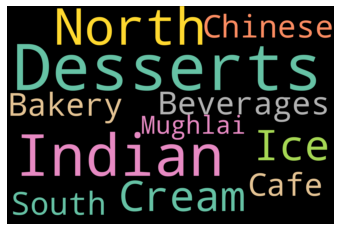

In [125]:
# Generate a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False,).generate(" ".join(top_10_cuisines["Cuisine"]))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [126]:
rename_map = {"Desserts, Beverages": "Beverages", "Ice Cream, Desserts": "Ice Cream", "Bakery, Desserts": "Bakery","North Indian, Chinese" : "Chinese", "North Indian, Mughlai": "Mughlai"}

In [127]:
top_10_cuisines = top_10_cuisines.rename(index=rename_map)

In [128]:
top_10_cuisines

Cuisine  Count
0           North Indian    483
1           South Indian    188
2    Desserts, Beverages    164
3               Desserts    142
4    Ice Cream, Desserts    133
5       Bakery, Desserts    115
6  North Indian, Chinese    107
7                   Cafe    102
8    Desserts, Ice Cream     99
9  North Indian, Mughlai     93

In [129]:
483 + 188 + 164 + 142 + 133 + 115 + 107 + 102 + 99 + 93 

1626

In [130]:
round(671/1626 * 100, 2)  #41.27% of the highest rated restaurants are Indian (North and South)

41.27

In [131]:
round(164/1626 * 100, 2) # 10% is beverages

10.09

In [132]:
round(591/1626 * 100, 2) #36.35% is for desserts

36.35

In [133]:
fig = px.bar(top_10_cuisines, x = 'Cuisine', y = 'Count', color= 'Cuisine', color_discrete_sequence=["Brown","BurlyWood", "DarkGreen", "DarkMagenta", "DarkRed", "DarkSalmon", "GoldenRod"])
fig.show()

In [134]:
top_10_cuisines.replace(rename_map, inplace=True)

In [135]:
top_10_cuisines

Cuisine  Count
0         North Indian    483
1         South Indian    188
2            Beverages    164
3             Desserts    142
4            Ice Cream    133
5               Bakery    115
6              Chinese    107
7                 Cafe    102
8  Desserts, Ice Cream     99
9              Mughlai     93

In [137]:
top_10_cuisines_lowest = lowest_ratings['cuisines'].value_counts().reset_index()[:10]

In [138]:
top_10_cuisines_lowest

index  cuisines
0                North Indian, Chinese       146
1                         North Indian       116
2  South Indian, North Indian, Chinese        48
3                                 Cafe        28
4                              Chinese        25
5                Chinese, North Indian        23
6     North Indian, Chinese, Fast Food        22
7                     Pizza, Fast Food        22
8  Chinese, South Indian, North Indian        22
9                              Biryani        20

In [139]:
top_10_cuisines_lowest.columns = ["Cuisine", "Count"]

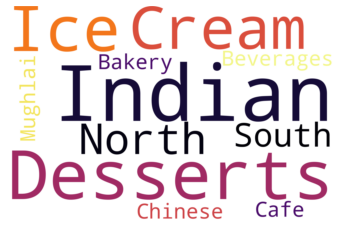

<Figure size 432x288 with 0 Axes>

In [140]:
# Generate a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='inferno', collocations=True).generate(" ".join(top_10_cuisines["Cuisine"]))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig("cuisines.png", format="png")

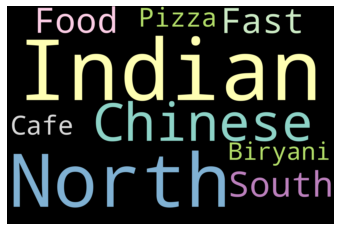

<Figure size 432x288 with 0 Axes>

In [141]:
# Generate a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set3', collocations=True,).generate(" ".join(top_10_cuisines_lowest["Cuisine"]))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig("cuisines.png", format="png")

### Services

In [142]:
highest_ratings.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'dish_liked', 'cuisines', 'approx_cost', 'reviews_list',
       'type', 'neighbourhood', 'text_clean', 'text_tokens'],
      dtype='object')

In [143]:
highest_ratings["type"].value_counts()

Delivery              4726
Dine-out              3904
Desserts               876
Cafes                  694
Drinks & nightlife     656
Buffet                 494
Pubs and bars          399
Name: type, dtype: int64

In [144]:
services = highest_ratings['type'].value_counts().reset_index()

In [145]:
services

index  type
0            Delivery  4726
1            Dine-out  3904
2            Desserts   876
3               Cafes   694
4  Drinks & nightlife   656
5              Buffet   494
6       Pubs and bars   399

In [146]:
services.columns = ["type of service", "count"]

In [147]:
fig = px.bar(services, x = 'type of service', y = 'count', color= 'type of service', color_discrete_sequence=["Brown","BurlyWood", "DarkGreen", "DarkMagenta", "DarkRed", "DarkSalmon", "GoldenRod"])
fig.show()

In [148]:
fig = px.pie(services, values='count', names='type of service', title='Type of Service', color_discrete_sequence=["PaleVioletRed","Beige", "FloralWhite", "IndianRed", "DarkRed", "DarkSalmon", "Pink"])
fig.show()

In [149]:
round(highest_ratings["online_order"].value_counts(normalize=True)*100, 2)

Yes    68.03
No     31.97
Name: online_order, dtype: float64

In [150]:
round(lowest_ratings["online_order"].value_counts(normalize=True)*100, 2) #More or less the same percentage

Yes    62.46
No     37.54
Name: online_order, dtype: float64

In [151]:
deliveries = highest_ratings['online_order'].value_counts().reset_index()

In [152]:
deliveries

index  online_order
0   Yes          7993
1    No          3756

In [153]:
deliveries.columns = ["Yes or No", "Online Order"]

In [154]:
fig = px.bar(deliveries, x = 'Yes or No', y = 'Online Order', color= 'Yes or No', color_discrete_sequence=["PaleVioletRed","Pink"])
fig.show()

### Locations

In [155]:
locations = highest_ratings['neighbourhood'].value_counts().reset_index()

In [156]:
locations

index  neighbourhood
0   Koramangala 7th Block            754
1   Koramangala 4th Block            737
2                     BTM            717
3   Koramangala 5th Block            714
4   Koramangala 6th Block            696
5                 MG Road            622
6           Church Street            615
7            Brigade Road            597
8             Indiranagar            573
9            Lavelle Road            549
10         Residency Road            517
11              Jayanagar            487
12       Old Airport Road            393
13               JP Nagar            344
14                    HSR            307
15           Malleshwaram            288
16            Frazer Town            280
17           Basavanagudi            275
18             Whitefield            266
19           Marathahalli            226
20              Bellandur            221
21            Brookefield            214
22           Kalyan Nagar            206
23          Sarjapur Road            205
24           Kammanahalli            205
25      Bannerghatta Road            194
26            Rajajinagar            189
27           Banashankari            139
28           New BEL Road            128
29        Electronic City             91

In [157]:
top_twenty_locations = locations[:20]

In [158]:
top_twenty_locations

index  neighbourhood
0   Koramangala 7th Block            754
1   Koramangala 4th Block            737
2                     BTM            717
3   Koramangala 5th Block            714
4   Koramangala 6th Block            696
5                 MG Road            622
6           Church Street            615
7            Brigade Road            597
8             Indiranagar            573
9            Lavelle Road            549
10         Residency Road            517
11              Jayanagar            487
12       Old Airport Road            393
13               JP Nagar            344
14                    HSR            307
15           Malleshwaram            288
16            Frazer Town            280
17           Basavanagudi            275
18             Whitefield            266
19           Marathahalli            226

In [159]:
top_twenty_locations.columns = ["neighbourhood", "number of ratings"]

In [160]:
fig_bar = px.bar(top_twenty_locations, x = 'number of ratings', y= 'neighbourhood', color= 'neighbourhood', color_discrete_sequence=["PaleVioletRed","Beige", "FloralWhite", "IndianRed", "DarkRed", "DarkSalmon", "Pink"], orientation='h')
fig_bar.update_layout(title= 'Distribution of the top 20 locations based on number of ratings')

fig_bar.show()

In [161]:
most_expensive = highest_ratings[highest_ratings["approx_cost"] > 850.00]

In [162]:
most_expensive

name online_order book_table  rate  \
315             The Royal Corner - Pai Viceroy          Yes        Yes   4.2   
404                                    Jalpaan          Yes        Yes   4.0   
863                          Deja Vu Resto Bar          Yes        Yes   4.4   
1673                         Deja Vu Resto Bar          Yes        Yes   4.4   
2464                         Deja Vu Resto Bar          Yes        Yes   4.4   
...                                        ...          ...        ...   ...   
50591                          Beyond Elements          Yes        Yes   4.1   
50923  Bloomsbury's Global Kitchen & Bakehouse          Yes        Yes   4.5   
51062  Bloomsbury's Global Kitchen & Bakehouse          Yes        Yes   4.5   
51098                          Beyond Elements          Yes        Yes   4.1   
51307                         The Kim Chi Chef          Yes         No   4.0   

       votes           location             rest_type  \
315      815          Jayanagar         Casual Dining   
404      866          Jayanagar         Casual Dining   
863     2487  Bannerghatta Road                   Pub   
1673    2487  Bannerghatta Road                   Pub   
2464    2488  Bannerghatta Road                   Pub   
...      ...                ...                   ...   
50591    869         Whitefield   Casual Dining, Cafe   
50923    756         Whitefield  Cafe, Dessert Parlor   
51062    756         Whitefield  Cafe, Dessert Parlor   
51098    869         Whitefield   Casual Dining, Cafe   
51307    210         Whitefield         Casual Dining   

                                              dish_liked  \
315    Breakfast Buffet, Kulcha, Almond Soup, Lunch B...   
404    Mocktails, Tomato Soup, Pasta, Nachos, Chaat, ...   
863    Gajar Ka Halwa, Chilli Chicken, Hara Bhara Keb...   
1673   Gajar Ka Halwa, Chilli Chicken, Hara Bhara Keb...   
2464   Gajar Ka Halwa, Chilli Chicken, Hara Bhara Keb...   
...                                                  ...   
50591  Masala Chaach, Dal Makhani, Pasta, Wood Fire P...   
50923  Pizza, Cheesecake, Burgers, Pasta, Waffles, Ve...   
51062  Pizza, Cheesecake, Burgers, Pasta, Waffles, Ve...   
51098  Masala Chaach, Dal Makhani, Pasta, Wood Fire P...   
51307                        Noodle, Momos, Manchow Soup   

                                                cuisines  approx_cost  \
315                                North Indian, Chinese        900.0   
404                            North Indian, Continental        900.0   
863                                North Indian, Italian        900.0   
1673                               North Indian, Italian        900.0   
2464                               North Indian, Italian        900.0   
...                                                  ...          ...   
50591                 Cafe, Italian, Pizza, North Indian        900.0   
50923  American, Cafe, Continental, French, Burger, M...        900.0   
51062  American, Cafe, Continental, French, Burger, M...        900.0   
51098                 Cafe, Italian, Pizza, North Indian        900.0   
51307                               Chinese, Thai, Momos        900.0   

                                            reviews_list                type  \
315    [('Rated 3.5', 'RATED\n  Been here for buffet ...            Delivery   
404    [('Rated 5.0', "RATED\n  I very rarely give a ...            Delivery   
863    [('Rated 5.0', "RATED\n  It's a what not resta...              Buffet   
1673   [('Rated 5.0', "RATED\n  It's a what not resta...            Delivery   
2464   [('Rated 5.0', "RATED\n  It's a what not resta...  Drinks & nightlife   
...                                                  ...                 ...   
50591  [('Rated 1.0', 'RATED\n  Nice place to hangout...            Delivery   
50923  [('Rated 5.0', 'RATED\n  Been here for a lunch...            Desserts   
51062  [('Rated 5.0', 'RATED\n  Been here for a lunch...            Dine-out  

In [163]:
round(most_expensive.groupby('neighbourhood', as_index=False).agg({"approx_cost": "mean"}), 2)

neighbourhood  approx_cost
0                     BTM       901.52
1            Banashankari       900.00
2       Bannerghatta Road       900.00
3            Basavanagudi       915.00
4               Bellandur       920.00
5            Brigade Road       900.00
6             Brookefield       900.00
7           Church Street       900.00
8         Electronic City       900.00
9             Frazer Town       916.67
10                    HSR       920.83
11            Indiranagar       906.25
12               JP Nagar       900.00
13              Jayanagar       908.82
14           Kalyan Nagar       900.00
15           Kammanahalli       900.00
16  Koramangala 4th Block       901.52
17  Koramangala 5th Block       900.00
18  Koramangala 6th Block       900.00
19  Koramangala 7th Block       900.00
20           Lavelle Road       900.00
21                MG Road       905.00
22           Malleshwaram       930.00
23           Marathahalli       900.00
24           New BEL Road       900.00
25       Old Airport Road       904.17
26         Residency Road       900.00
27          Sarjapur Road       900.00
28             Whitefield       900.00

In [164]:
price_average = round(highest_ratings.groupby('neighbourhood', as_index=False).agg({"approx_cost": "mean"}), 2)

In [165]:
highest_ratings

name online_order  \
0                                                  Jalsa          Yes   
1                                         Spice Elephant          Yes   
7                                                 Onesta          Yes   
8                                         Penthouse Cafe          Yes   
9                                              Smacznego          Yes   
...                                                  ...          ...   
51700                                            BAR BAR           No   
51701                                      The Beer Cafe          Yes   
51702                                  Pablo's Gastrobar           No   
51704                                            Smaaash           No   
51715  Chime - Sheraton Grand Bengaluru Whitefield Ho...           No   

      book_table  rate  votes                    location  \
0            Yes   4.1    775                Banashankari   
1             No   4.1    787                Banashankari   
7            Yes   4.6   2556                Banashankari   
8             No   4.0    324                Banashankari   
9             No   4.2    504                Banashankari   
...          ...   ...    ...                         ...   
51700        Yes   4.1   1003                  Whitefield   
51701        Yes   4.1    673                  Whitefield   
51702         No   4.0   1094                  Whitefield   
51704        Yes   4.0    189                  Whitefield   
51715        Yes   4.3    236  ITPL Main Road, Whitefield   

                 rest_type                                         dish_liked  \
0            Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1            Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
7      Casual Dining, Cafe  Farmhouse Pizza, Chocolate Banana, Virgin Moji...   
8                     Cafe  Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...   
9                     Cafe  Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...   
...                    ...                                                ...   
51700   Bar, Casual Dining  Mocktails, Cocktails, Pizza, Chicken Tikka, Na...   
51701                  Pub  Cocktails, Wheat Beer, Bruschettas, Pasta, Bur...   
51702                  Bar  Cocktails, Beer, Pizza, Long Island Iced Tea, ...   
51704   Casual Dining, Pub                                        Pizza, Beer   
51715                  Bar                       Cocktails, Pizza, Buttermilk   

                                          cuisines  approx_cost  \
0                   North Indian, Mughlai, Chinese       800.00   
1                      Chinese, North Indian, Thai       800.00   
7                             Pizza, Cafe, Italian       600.00   
8                       Cafe, Italian, Continental       700.00   
9         Cafe, Mexican, Italian, Momos, Beverages       550.00   
...                                            ...          ...   
51700           Continental, North Indian, Italian         1.50   
51701  Finger Food, North Indian, Chinese, Italian         1.40   
51702        Finger Food, American, Asian, Italian         1.45   
51704                 North Indian, Pizza, Chinese         1.50   
51715                                  Finger Food         2.50   

                                            reviews_list           type  \
0      [('Rated 4.0', 'RATED\n  A beautiful place to ...         Buffet   
1      [('Rated 4.0', 'RATED\n  Had been here for din...         Buffet   
7      [('Rated 5.0', 'RATED\n  I personally really l...          Cafes   
8      [('Rated 3.0', "RATED\n  I had been to this pl...          Cafes   
9      [('Rated 4.0', "RATED\n  Easy to locate\nVFM 3...          Cafes   
...                                                  ...            ...   
51700  [('Rated 4.0', "RATED\n  In an increasingly ov...  Pubs and bars   
51701  [('Rated 2.0', "RATED\n  We went out to this p...  Pubs a

In [166]:
price_average

neighbourhood  approx_cost
0                     BTM       363.98
1            Banashankari       423.86
2       Bannerghatta Road       370.34
3            Basavanagudi       429.08
4               Bellandur       256.29
5            Brigade Road       239.89
6             Brookefield       366.11
7           Church Street       230.10
8         Electronic City       283.60
9             Frazer Town       342.99
10                    HSR       394.86
11            Indiranagar       296.72
12               JP Nagar       372.15
13              Jayanagar       398.76
14           Kalyan Nagar       402.08
15           Kammanahalli       413.50
16  Koramangala 4th Block       384.34
17  Koramangala 5th Block       361.47
18  Koramangala 6th Block       382.77
19  Koramangala 7th Block       365.11
20           Lavelle Road       233.24
21                MG Road       234.90
22           Malleshwaram       293.77
23           Marathahalli       321.77
24           New BEL Road       437.80
25       Old Airport Road       294.22
26            Rajajinagar       279.75
27         Residency Road       236.95
28          Sarjapur Road       257.08
29             Whitefield       270.01

In [167]:
expensive_n = price_average.sort_values(by=['approx_cost'], ascending = False).head(5) #the most expensive neighbourhoods

In [168]:
expensive_n

neighbourhood  approx_cost
24  New BEL Road       437.80
3   Basavanagudi       429.08
1   Banashankari       423.86
15  Kammanahalli       413.50
14  Kalyan Nagar       402.08

In [169]:
cheapest_n = price_average.sort_values(by=['approx_cost'], ascending = True).head(5) #the cheapest neighbourhoods

In [170]:
cheapest_n

neighbourhood  approx_cost
7    Church Street       230.10
20    Lavelle Road       233.24
21         MG Road       234.90
27  Residency Road       236.95
5     Brigade Road       239.89

# 6. Topic Modeling

## Latent Dirichlet Allocation (LDA)

In [171]:
import gensim
from gensim import corpora

In [172]:
dictionary = corpora.Dictionary(highest_ratings['text_tokens'])

In [173]:
print(dictionary.token2id)

{'ages': 0, 'ala': 1, 'alacarteã': 2, 'alice': 3, 'allthe': 4, 'along': 5, 'always': 6, 'amazing': 7, 'ambiance': 8, 'ambience': 9, 'anymore': 10, 'anyways': 11, 'arrangement': 12, 'atmosphere': 13, 'authentic': 14, 'available': 15, 'baby': 16, 'back': 17, 'banashankari': 18, 'basement': 19, 'bda': 20, 'beautiful': 21, 'best': 22, 'betterwould': 23, 'bhutta': 24, 'breads': 25, 'buffet': 26, 'builds': 27, 'butter': 28, 'canã': 29, 'carte': 30, 'chaap': 31, 'cheers': 32, 'chicken': 33, 'chill': 34, 'chilli': 35, 'christmas': 36, 'clearly': 37, 'coll': 38, 'combonlemon': 39, 'come': 40, 'comfortable': 41, 'complaint': 42, 'completely': 43, 'compromised': 44, 'concern': 45, 'congested': 46, 'corn': 47, 'corrionder': 48, 'could': 49, 'cumbersome': 50, 'curry': 51, 'definitely': 52, 'dessert': 53, 'dine': 54, 'dinner': 55, 'disappointed': 56, 'dish': 57, 'empty': 58, 'era': 59, 'essence': 60, 'ethnic': 61, 'expensive': 62, 'experience': 63, 'family': 64, 'fan': 65, 'firstly': 66, 'foodnchees

In [174]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in highest_ratings['text_tokens']]
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.

In [175]:
doc_term_matrix[15]

[(6, 2),
 (9, 2),
 (17, 1),
 (22, 3),
 (47, 1),
 (52, 4),
 (53, 2),
 (56, 1),
 (62, 1),
 (65, 1),
 (70, 2),
 (74, 3),
 (86, 2),
 (96, 1),
 (104, 4),
 (106, 1),
 (115, 1),
 (129, 2),
 (130, 3),
 (139, 1),
 (153, 2),
 (158, 1),
 (206, 4),
 (222, 1),
 (224, 1),
 (231, 1),
 (240, 1),
 (260, 1),
 (268, 5),
 (285, 1),
 (296, 1),
 (326, 1),
 (330, 1),
 (331, 2),
 (335, 3),
 (357, 1),
 (393, 1),
 (402, 3),
 (432, 2),
 (462, 1),
 (467, 6),
 (468, 1),
 (476, 1),
 (479, 1),
 (490, 1),
 (491, 1),
 (492, 1),
 (493, 1),
 (502, 2),
 (503, 1),
 (513, 1),
 (524, 1),
 (558, 1),
 (560, 3),
 (576, 1),
 (606, 1),
 (623, 1),
 (638, 1),
 (646, 1),
 (671, 1),
 (672, 2),
 (698, 1),
 (775, 1),
 (795, 1),
 (829, 3),
 (844, 1),
 (845, 1),
 (902, 1),
 (932, 1),
 (977, 1),
 (1030, 1),
 (1130, 1),
 (1136, 1),
 (1153, 1),
 (1164, 1),
 (1207, 1),
 (1213, 2),
 (1214, 1),
 (1219, 6),
 (1240, 1),
 (1268, 2),
 (1275, 1),
 (1355, 1),
 (1426, 1),
 (1483, 1),
 (1490, 1),
 (1503, 1),
 (1580, 1),
 (1586, 1),
 (1600, 1),
 (1648

In [176]:
for word_id, count in doc_term_matrix[11]:
    print(word_id,dictionary[word_id])
    print('--------')

5 along
--------
9 ambience
--------
16 baby
--------
17 back
--------
18 banashankari
--------
22 best
--------
33 chicken
--------
35 chilli
--------
47 corn
--------
52 definitely
--------
55 dinner
--------
57 dish
--------
64 family
--------
69 fried
--------
70 friendly
--------
72 friends
--------
73 go
--------
74 good
--------
75 great
--------
86 itã
--------
91 lemon
--------
94 lot
--------
103 music
--------
104 must
--------
105 near
--------
129 quality
--------
130 quite
--------
133 rice
--------
136 said
--------
139 service
--------
142 soup
--------
144 staff
--------
153 taste
--------
158 times
--------
168 veg
--------
177 worth
--------
178 would
--------
179 wrong
--------
184 affordable
--------
186 appetite
--------
191 bad
--------
194 bit
--------
205 chinese
--------
216 course
--------
223 decided
--------
233 drink
--------
241 find
--------
242 fine
--------
243 first
--------
250 garlic
--------
252 get
--------
263 heavy
--------
268 ice
--------
269 

In [177]:
#Create and fit the LDA model
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, 
               passes=20) #num of passes through the corpus during training.

# c) Extract word distributions for the optimized topics from LDA model



In [178]:
for i in ldamodel.print_topics():
    print('Topic number {} \n'.format(i[0]))
    for j in i: 
        print (j)
        print('......................')

Topic number 0 

0
......................
0.022*"good" + 0.010*"chicken" + 0.009*"pizza" + 0.008*"ambience" + 0.008*"great" + 0.008*"service" + 0.007*"nice" + 0.006*"cheese" + 0.006*"burger" + 0.006*"cafe"
......................
Topic number 1 

1
......................
0.019*"good" + 0.009*"chicken" + 0.008*"taste" + 0.006*"service" + 0.006*"best" + 0.006*"great" + 0.005*"must" + 0.005*"biryani" + 0.005*"chocolate" + 0.005*"well"
......................
Topic number 2 

2
......................
0.029*"good" + 0.012*"ambience" + 0.012*"service" + 0.012*"great" + 0.011*"chicken" + 0.007*"nice" + 0.007*"staff" + 0.007*"music" + 0.006*"amazing" + 0.006*"drinks"
......................


In [179]:
dir(ldamodel)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_lifecycle_event',
 'alpha',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'lifecycle_events',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offse

In [180]:
first_topic_words = dict(ldamodel.show_topic(0,1000))
second_topic_words = dict(ldamodel.show_topic(1,1000))
third_topic_words = dict(ldamodel.show_topic(2,1000))

In [181]:
def visualize_wordcloud_dict_frequencies(dict_freqs, title, relative_scaling=0.5, max_words=100,
                                background_color='black'):
    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(width=900, height=500, max_words=max_words, relative_scaling=relative_scaling,
                          normalize_plurals=False, background_color=background_color).generate_from_frequencies(
        dict_freqs)
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

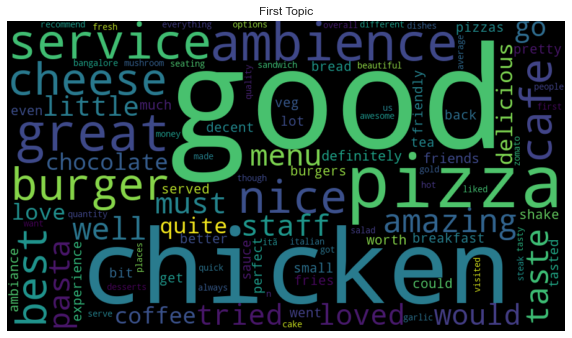

In [182]:
visualize_wordcloud_dict_frequencies(first_topic_words, "First Topic", relative_scaling=0.5, max_words=100,
                                background_color='black')

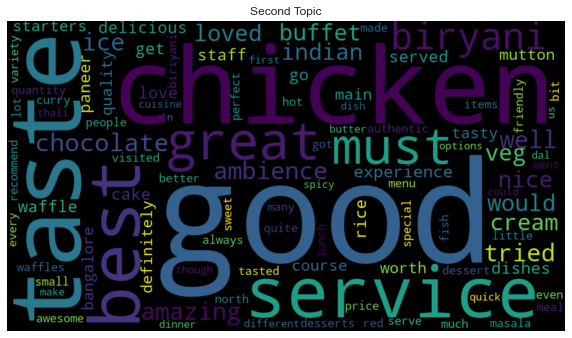

In [183]:
visualize_wordcloud_dict_frequencies(second_topic_words, "Second Topic", relative_scaling=0.5, max_words=100,
                                background_color='black')

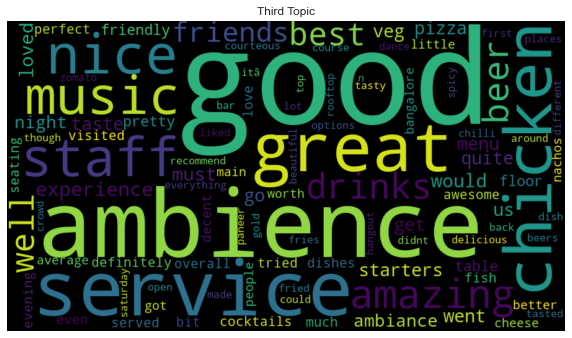

In [184]:
visualize_wordcloud_dict_frequencies(third_topic_words, "Third Topic", relative_scaling=0.5, max_words=100,
                                background_color='black')

In [185]:
#visualize_wordcloud_dict_frequencies(fourth_topic_words, "Fourth Topic", relative_scaling=0.5, max_words=100,
#                                background_color='black')

IndentationError: unexpected indent (1115296874.py, line 2)

In [ ]:
#visualize_wordcloud_dict_frequencies(fifth_topic_words, "Fifth Topic", relative_scaling=0.5, max_words=100,
                                background_color='black')

In [186]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)

/Users/patri/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/patri/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/patri/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/patri/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/patri/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py

/Users/patri/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/patri/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/patri/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/patri/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/patri/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are depreca

In [187]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.061088  0.060935       1        1  40.346735
0     -0.039935 -0.070079       2        1  30.864907
1      0.101023  0.009144       3        1  28.788358, topic_info=        Term          Freq          Total Category  logprob  loglift
712     beer  51008.000000   51008.000000  Default  30.0000  30.0000
618    pizza  87527.000000   87527.000000  Default  29.0000  29.0000
450     cafe  38632.000000   38632.000000  Default  28.0000  28.0000
722   burger  42558.000000   42558.000000  Default  27.0000  27.0000
193  biryani  34440.000000   34440.000000  Default  26.0000  26.0000
..       ...           ...            ...      ...      ...      ...
231   dishes  17908.588614   49958.536600   Topic3  -5.8108   0.2193
107     nice  22263.762437  126315.391160   Topic3  -5.5931  -0.4906
73        go  18843.319213   72145.960617   Topic3  -5.7599  -0.0973
144    staff  19244.704012  107027.761955   Topic3  -5.7388  -0.4707
650   served  17944.691375   55427.157493   Topic3  -5.8088   0.1174

[306 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
6195       1  0.997227    ale
6195       2  0.000416    ale
6195       3  0.002493    ale
1517       1  0.020600   aloo
1517       2  0.103002   aloo
...      ...       ...    ...
175        3  0.237725   went
178        1  0.402899  would
178        2  0.318395  would
178        3  0.278702  would
51175      2  0.998379   xbox

[487 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])